# Sentiment Analysis Recommendation System 

## Group: U_Data

    Members:
    
    Aroob Almutairi 
    
    Abdulrahman Alosaimi
    
    Duaa Al saad 
    
    Fatimah Alateeq
    
    Ghaliah mohammedhussein

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


**Part One:**
Installing needed packages

In [3]:
!pip install pyarabic
!pip install emoji
!pip install pystemmer
!pip install optuna==2.3.0
!pip install transformers==4.2.1
!pip install arabic_reshaper
!pip install python-bidi
!pip install ar_wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import needed packages

In [4]:
import numpy as np
import pandas as pd
import pyarabic.araby as ar
import re , emoji, Stemmer, functools, operator, string
import torch , optuna, gc, random, os
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample

import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)


import matplotlib.pyplot as plt 
import seaborn as sns

from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display
from ar_wordcloud import ArabicWordCloud

%matplotlib inline 


**Part 4:** Define cleaning method

In [5]:
df_NLP= pd.read_csv('Cleaned_data_set/clean_NLP_data_set.csv')
df_NLP

,Unnamed: 0,tweet,label
0,16,اف مافي شي راضي يزبط,anger
1,2011,مبسوطه واحساس بالراحه وتنفس مريح,joy
2,3493,متعاطفه مرا مع هذا الشخص,sympathy
3,1693,أنا مكتئبة جدا احتاج عزلة عن الناس,sadness
4,1107,احساس بعدم الراحه قلق وشك نبضات قلب سريعه تنفس...,fear
...,...,...,...
4016,2732,انا اقوى من الملل,bored
4017,869,مره يعصب صدق,anger
4018,3606,اشعر بنيران تخرج من عيناي,anger
4019,2896,مصدومة,surprise


In [7]:
df_NLP.dropna(inplace=True)
df_NLP.rename(columns = {'TWEET':'tweet', 'LABEL':'label'}, inplace = True)
df_NLP

,Unnamed: 0,tweet,label
0,16,اف مافي شي راضي يزبط,anger
1,2011,مبسوطه واحساس بالراحه وتنفس مريح,joy
2,3493,متعاطفه مرا مع هذا الشخص,sympathy
3,1693,أنا مكتئبة جدا احتاج عزلة عن الناس,sadness
4,1107,احساس بعدم الراحه قلق وشك نبضات قلب سريعه تنفس...,fear
...,...,...,...
4016,2732,انا اقوى من الملل,bored
4017,869,مره يعصب صدق,anger
4018,3606,اشعر بنيران تخرج من عيناي,anger
4019,2896,مصدومة,surprise


In [8]:
df_NLP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4021 entries, 0 to 4020
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4021 non-null   int64 
 1   tweet       4021 non-null   object
 2   label       4021 non-null   object
dtypes: int64(1), object(2)
memory usage: 125.7+ KB


In [9]:
df_NLP['tweet']=df_NLP['tweet'].str.replace(r'\:', '', regex=True)
df_NLP['tweet']=df_NLP['tweet'].str.replace(r'\.', '', regex=True)
df_NLP['tweet']=df_NLP['tweet'].str.replace(r'\%', '', regex=True)


In [10]:
df_NLP['tweet']=df_NLP['tweet'].str.replace(r'\s*[A-Za-z]+\b', '', regex=True)
df_NLP['tweet']=df_NLP['tweet'].str.replace(r'\s*[0-9]+\b', '', regex=True)
df_NLP['tweet']=df_NLP['tweet'].str.replace(r'[^\w\s]', '', regex=True)

In [11]:
df_NLP['tweet']

0                                    اف مافي شي راضي يزبط
1                        مبسوطه واحساس بالراحه وتنفس مريح
2                                متعاطفه مرا مع هذا الشخص
3                     أنا مكتئبة جدا  احتاج عزلة عن الناس
4       احساس بعدم الراحه قلق وشك نبضات قلب سريعه تنفس...
                              ...                        
4016                                    انا اقوى من الملل
4017                                         مره يعصب صدق
4018                            اشعر بنيران تخرج من عيناي
4019                                               مصدومة
4020                                       الرحمة والحكمة
Name: tweet, Length: 4021, dtype: object

In [12]:
df_NLP_new = df_NLP.sample(frac = 1)
df_NLP_new.reset_index(drop=True)

,Unnamed: 0,tweet,label
0,462,مافيه اي مكان نروح له,bored
1,807,انعدام الشعور والرغبه باحداث اشياء جديده تيقظ ...,bored
2,3193,ماذا تقولين,surprise
3,1140,اخ ي القهر,anger
4,371,ممل والله,bored
...,...,...,...
4016,1146,غياب الحكمة وغالبا سوء تصرف,anger
4017,1609,سويت هالشي عشانك,sympathy
4018,3581,اخ ي القهر,anger
4019,594,لربما احاديثي معي أمتع من هذا,bored


# EDA



In [13]:
text = df_NLP_new['tweet']
text = [''.join(sentence) for sentence in text]
text = ''.join(text)


downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoNaskhArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoSansArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoKufiArabic-unhinted.zip .. 


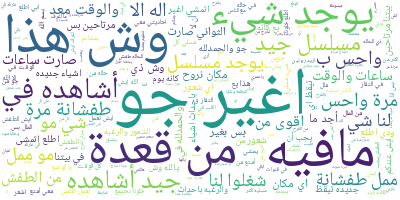

In [14]:
awc = ArabicWordCloud(background_color="white")
reshaped_text = arabic_reshaper.reshape(text)
arabic_text = get_display(reshaped_text)
wc = awc.from_text(arabic_text)
wc.generate(arabic_text)
wc.to_image()

In [15]:
text = df_NLP_new['label']
print(text)
text = ' '.join(text)

1314       bored
2752       bored
1897    surprise
2315       anger
3912       bored
          ...   
25         anger
856     sympathy
2467       anger
2713       bored
712     surprise
Name: label, Length: 4021, dtype: object


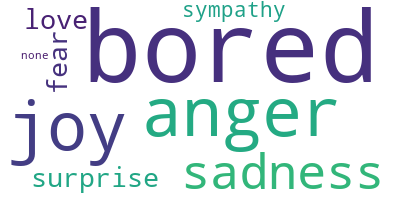

In [16]:
wordcloud = WordCloud(background_color="white").generate(text)
wordcloud.to_image()
